## Analysis of normative curves of morphological hippocampi

This notebook is used to create Supplementary Figure 1B and Figure 2A of the manuscript

- Create normative curves of the features in healthy population

- Analyse where the ipsilateral/contralateral and disease controls hippocampi fell onto the percentiles of the healthy population

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
from aidhs.paths import BASE_PATH 
from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject


Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript


In [2]:
hemis=['lh', 'rh']

#create cohort to smooth
cohort= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_avg.hdf5', dataset='dataset_C-P-DC_alltrain.csv')

#get feature list
features = cohort.full_feature_list

#get subjects 
subjects = cohort.get_subject_ids(group='both', lesional_only = False)

len(subjects)

363

In [3]:
features=[
    '.label-{}.curvature.sm1',
    '.label-{}.gauss-curv_filtered_sm1',
    '.label-{}.gyrification.sm1',
    '.label-{}.thickness.sm1',
    '.label-avg.hippunfold_volume',
    '.label-avg.FS_volume',
     '.label-avg.hippunfold_volume_icvcorr',
    '.label-avg.FS_volume_icvcorr',
    ]

features = ['.combat'+feature.format('avg') for feature in features]


features_title = {
                '.curvature' : ' mean curvature',
                '.gauss-curv_filtered': 'intrinsic curvature ',
                '.gyrification' : 'gyrification ',
                '.thickness' : 'thickness (mm) ',
                '.hippunfold_volume' :'volume (mm$^3$)',
    }

In [4]:
# create dataframe with subjects features and demographic information

def is_nan(x):
    return (x != x)

ages = []

df=pd.DataFrame()
for subject in subjects:
    # create subject object
    subj = AidhsSubject(subject, cohort=cohort)
    group=subj.get_demographic_features("group")
    if group=='P':
        lesional_hemi = subj.get_demographic_features("Lesional hemi")
    elif group=='DC':
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    else:
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    for hemi in hemis:
        values={}
        #get demographic info 
        values['ID']=subj.subject_id
        values['group']=group
        values['hemi'] = hemi
        values['site'], values['age_scan'], values['sex'], values['mri_neg'], values['age_onset'], values['epilepsy_duration']= subj.get_demographic_features(["Site","Age at preoperative", "Sex", "Ever reported MRI negative", "Age of onset of epilepsy","Duration of Epilepsy"])
        if is_nan(lesional_hemi):
            values['lesional'] = np.nan
        elif hemi==lesional_hemi:
            values['lesional'] = 'ipsi'
        else:
            values['lesional'] = 'contra'
        #get structural and intensity features        
        for feature in features:
            vals = subj.load_feature_values(feature, hemi)
            if vals.sum()!=0:
                values[feature]=vals[0]
            else:
                pass
        # save values for each subject in panda matrix
        df2 = pd.DataFrame([values])
        df = pd.concat([df,df2],ignore_index=True)


In [2]:
# #load or save dataframe
output_path=os.path.join(BASE_PATH,'data_saved')
file = os.path.join(output_path,'matrix_features_combat_avg_230920.csv')   
# df.to_csv(file)
df=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)

In [3]:
df.head()

,ID,group,hemi,site,age_scan,sex,mri_neg,age_onset,epilepsy_duration,lesional,.combat.label-avg.curvature.sm1,.combat.label-avg.gauss-curv_filtered_sm1,.combat.label-avg.gyrification.sm1,.combat.label-avg.thickness.sm1,.combat.label-avg.hippunfold_volume,.combat.label-avg.FS_volume,.combat.label-avg.hippunfold_volume_icvcorr,.combat.label-avg.FS_volume_icvcorr
0,AIDHSH29P0001,P,lh,H29,43.0,0.0,0.0,17.0,26.0,ipsi,0.190748,0.036680,2.176642,1.432983,1751.3384,3106.6167,1733.2833,3062.3877
1,AIDHSH29P0001,P,rh,H29,43.0,0.0,0.0,17.0,26.0,contra,0.177748,0.031206,2.544395,1.472283,2179.5810,4121.9653,2153.0337,4091.5474
2,AIDHSH29P0002,P,lh,H29,26.0,1.0,0.0,0.8,25.2,ipsi,0.222976,0.034936,2.117792,1.375277,1561.5272,2963.8160,1580.4385,3016.2446
3,AIDHSH29P0002,P,rh,H29,26.0,1.0,0.0,0.8,25.2,contra,0.171138,0.028760,2.824229,1.459554,2542.4072,4249.6300,2567.2920,4291.9062
4,AIDHSH29P0003,P,lh,H29,20.0,0.0,0.0,13.0,7.0,ipsi,0.203764,0.040068,1.849356,1.435530,1412.2097,3304.8990,1390.6628,3252.7850


### Plot normative curves of morphological features in healthy population

In [5]:
def return_features_title(feature, features_title):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]


def plot_controls_chart(ax, data_c, feature, color = 'green', cmap=False, fill_color=True, label=None):
    if cmap != False:
        cmap = matplotlib.cm.get_cmap(cmap)

    #plot percentiles 
    percentiles = np.sort(list(set(data_c['predict_vals_intervals'])))
    for p, percentile in enumerate(percentiles):
        if cmap != False:
            color = cmap(abs(0.5-percentile))
        if percentile == 0.5:
            ax.plot(data_c['age_range'],data_c['predict_vals_intervals'][percentile], color=color, 
                        ls='-', linewidth= 1, alpha=1, label = label)
        else:
            ax.plot(data_c['age_range'],data_c['predict_vals_intervals'][percentile], color=color, 
                        ls='--',linewidth= 1,  alpha=1)
        # ax.text(data_c['age_range'][-1], data_c['predict_vals_intervals'][percentile][-1], f'{int(percentile*100)}',
        #             fontsize = 10, color=color)   
    
    #fill between line
    if fill_color:
        if len(percentiles)>1:
            bands = np.delete(percentiles, np.where(percentiles == 0.5))
            colors = np.linspace(0,1,len(bands)-1)-0.5
            for b, band in enumerate(bands[0:-1]):
                color = cmap(abs(colors[b]))
                ax.fill_between(data_c['age_range'], data_c['predict_vals_intervals'][band], data_c['predict_vals_intervals'][bands[b+1]], 
                                        facecolor=color, alpha=0.5, interpolate=True)

    #details plot 
    ax.set_xlim([data_c['age_range'][0], data_c['age_range'][-1]])
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)
    ax.set_ylabel(return_features_title(feature, features_title), fontsize=15)
    ax.set_xlabel('age (years)', fontsize=12)


def fit_GAM_age_sex(vals, age, sex, fit_log=False, percents=np.array([0.95]), splines=5, add_mid_curve=True):
    from pygam import ExpectileGAM, LinearGAM, s, f
    X = np.zeros((len(vals),2))
    if fit_log:
        X[:,0]=np.log(age)
    else:
        X[:,0]=age
    X[:,1]=sex
    y=vals

    # lets fit the mean model first by CV
    gam50 = ExpectileGAM(s(0) + f(1), expectile=0.5, n_splines=splines).gridsearch(X, y)
    # and copy the smoothing to the other models
    lam = gam50.lam

    #create grid
    if fit_log:
        age_range_log=np.linspace(1.3,4.2,100)
        age_range = np.exp(age_range_log)
        XX = np.zeros((len(age_range),2))
        XX[:,0]=age_range_log
    else:
        age_range = np.linspace(3,65,100)
        XX = np.zeros((len(age_range),2))
        XX[:,0]=age_range

    data_dict = {}
    for sex_ind in [0,1]:
        data_dict[sex_ind]={}
        sex_range = np.ones(len(XX))*sex_ind
        XX[:,1] = sex_range

        data_dict[sex_ind]['age_range'] = age_range

        predict_vals_intervals=[]
        data_dict[sex_ind]['predict_vals_intervals']={}
        for percent in percents:
            gam = ExpectileGAM(expectile=percent, lam=lam, n_splines=splines).fit(X, y)
            predict_vals_intervals = gam.predict(XX)
            data_dict[sex_ind]['predict_vals_intervals'][percent] = predict_vals_intervals
    
    if add_mid_curve == True:
        data_dict[sex_ind]['predict_vals_intervals'][0.5] = gam50.predict(XX)

    return data_dict


In [6]:
output_path=os.path.join(BASE_PATH,'images')

#### Plot GAM curves for controls

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:  00:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |#######################

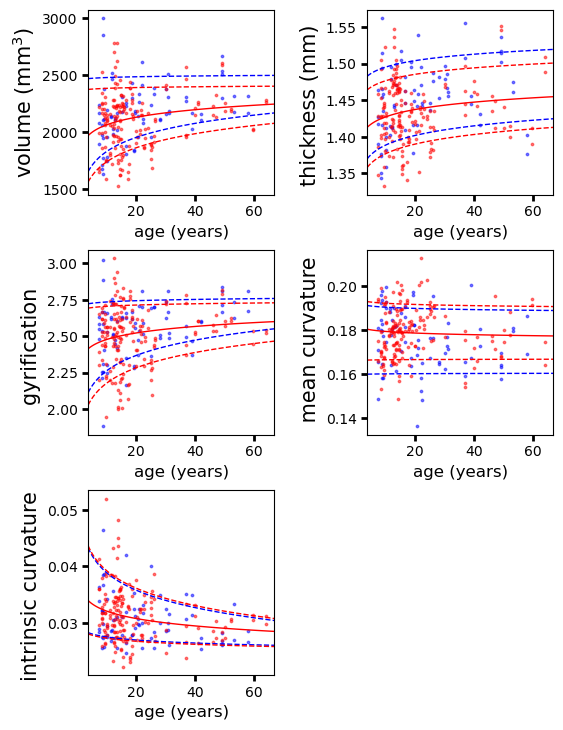

In [7]:
from matplotlib.gridspec import GridSpec

sub_features=[
'.combat.label-avg.hippunfold_volume_icvcorr',
 '.combat.label-avg.thickness.sm1',
 '.combat.label-avg.gyrification.sm1',
 '.combat.label-avg.curvature.sm1',
 '.combat.label-avg.gauss-curv_filtered_sm1',
 ]

x_variable = 'age_scan' 
sexes=['male','female']
colors_maps = ['Blues_r', 'Red_s']
colors = ['blue', 'red']
fit_GAM=True
fit_log=True
percents = np.array([0.05,0.95])

fig = plt.figure(figsize=(6,18))
gs1 = GridSpec(6, 2, wspace=0.5, hspace=0.3)
axs = []


matrix_coefs= np.zeros((len(sub_features),3))
matrix_pvals= np.zeros((len(sub_features),3))

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))
    subdf = df.dropna(subset=[feature])


    #plot controls 
    subdf_c = subdf[subdf['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    vals_c = subdf_c[feature].copy()

    if fit_GAM:
        controls_GAM = fit_GAM_age_sex(vals_c, age_c, sex_c, fit_log=fit_log, percents=percents, splines=4,  add_mid_curve=True)
        
    for sex_i, sex in enumerate(sexes):
        mask=(sex_c == sex_i)
        axs[i].scatter(age_c[mask],vals_c[mask],c=colors[sex_i], s=3, alpha=0.5, label=f'healthy {sex} controls')
        if fit_GAM:
             im = plot_controls_chart(axs[i], controls_GAM[sex_i], feature, color=colors[sex_i], fill_color=False, label=f'percentiles GAM curves - {sex}s ')
    
plt.tight_layout()
fig.savefig(os.path.join(output_path, 'charts_combat_features_controls.png'), dpi=96, transparent =True, bbox_inches = 'tight' )    


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

for sex_i, sex in enumerate(sexes):
    ax.scatter(1,1, c=colors[sex_i], s=3, alpha=0.5, label=f'healthy {sex} controls')
for sex_i, sex in enumerate(sexes):
    ax.plot([0,0],[0,0], c=colors[sex_i], ls='-', linewidth= 1, alpha=1,  label=f'percentiles GAM curves - {sex}s ')

h, l =  ax.get_legend_handles_labels() # get labels and handles from ax1
ax.legend(h, l, markerscale=2., scatterpoints=1, loc='center left', fontsize=18)
ax.axis('off')

fig.savefig(os.path.join(output_path, 'legend_charts_combat_features_controls.png'), dpi=96, transparent =True, bbox_inches = 'tight' )

### Save GAM curves for individual reports

In [9]:
import pickle as pickle

sub_features=[
'.combat.label-avg.hippunfold_volume_icvcorr',
 '.combat.label-avg.thickness.sm1',
 '.combat.label-avg.gyrification.sm1',
 '.combat.label-avg.curvature.sm1',
 '.combat.label-avg.gauss-curv_filtered_sm1',
 ]

x_variable = 'age_scan' 
fit_log=True
percents = np.array([0.05, 0.25, 0.75, 0.95])

controls_GAM = {}
for i,feature in enumerate(sub_features):
    subdf = df.dropna(subset=[feature])
    
    #get controls 
    subdf_c = subdf[subdf['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    vals_c = subdf_c[feature].copy()

    controls_GAM[feature] = fit_GAM_age_sex(vals_c, age_c, sex_c, fit_log=fit_log, percents=percents, splines=4,  add_mid_curve=True)

data_path='/home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript/data_saved'   
filename = os.path.join(data_path, 'GAM_curves_controls.pkl' ) 
with open(filename, 'wb') as handle:
    pickle.dump(controls_GAM, handle, protocol=pickle.HIGHEST_PROTOCOL)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        

#### Add patients ispilateral and contralateral, and disease controls hippocampi on normative curves

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:  00:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########             

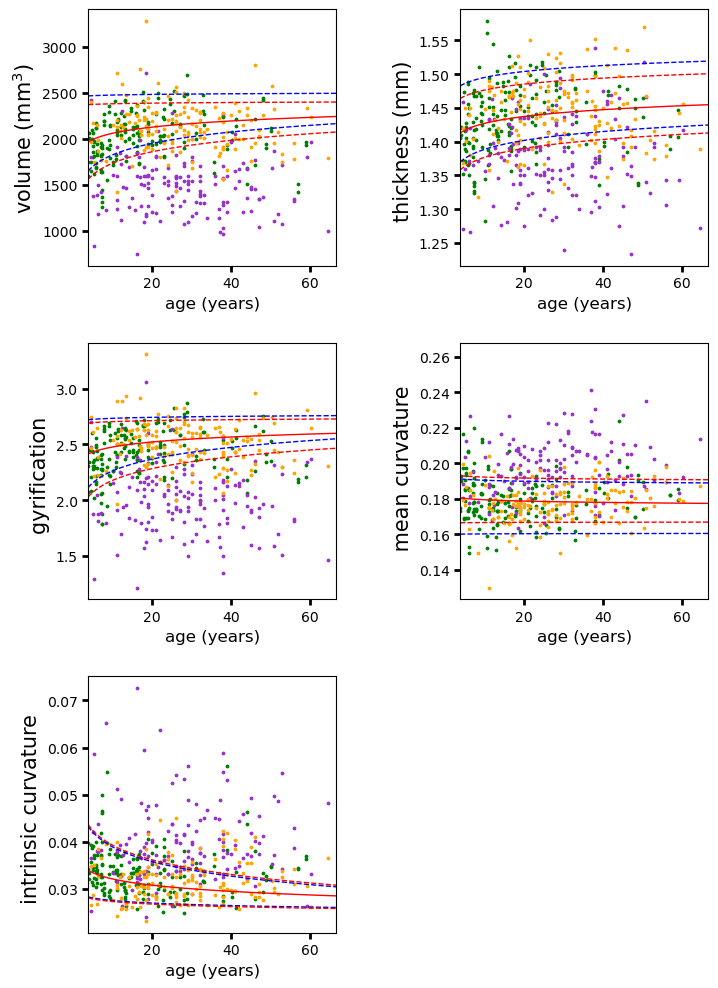

In [9]:
from matplotlib.gridspec import GridSpec

sub_features=[
'.combat.label-avg.hippunfold_volume_icvcorr',
 '.combat.label-avg.thickness.sm1',
 '.combat.label-avg.gyrification.sm1',
 '.combat.label-avg.curvature.sm1',
 '.combat.label-avg.gauss-curv_filtered_sm1',
 ]

x_variable = 'age_scan' 
sexes=['male','female']
colors = ['blue', 'red']
fit_GAM=True
fit_log=True
percents = np.array([0.05, 0.95])

fig = plt.figure(figsize=(8,12))
gs1 = GridSpec(3, 2, wspace=0.5, hspace=0.3)
axs = []


matrix_coefs= np.zeros((len(sub_features),3))
matrix_pvals= np.zeros((len(sub_features),3))

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))
    subdf = df.dropna(subset=[feature])


    #plot controls 
    subdf_c = subdf[subdf['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    vals_c = subdf_c[feature].copy()

    if fit_GAM:
        controls_GAM = fit_GAM_age_sex(vals_c, age_c, sex_c, fit_log=fit_log, percents=percents, splines=4, add_mid_curve=True)
        
    for sex_i, sex in enumerate(sexes):
        if fit_GAM:
            im = plot_controls_chart(axs[i], controls_GAM[sex_i], feature, color=colors[sex_i], fill_color=False, label=f'percentiles GAM curves - {sex}s')
    
        
    #plot disease controls 
    subdf_dc = subdf[subdf['group']=='DC']
    age_dc = subdf_dc[x_variable].copy()
    sex_dc = subdf_dc['sex'].copy()
    vals_dc = subdf_dc[feature].copy()
    axs[i].scatter(age_dc,vals_dc,c='green',s=3, alpha=1, label='disease controls')

    #plot patient ipsi
    subdf_pi = subdf[(subdf['group']=='P')&(subdf['lesional']=='ipsi')]
    age_pi = subdf_pi[x_variable].copy()
    sex_pi = subdf_pi['sex'].copy()
    vals_pi = subdf_pi[feature].copy()
    axs[i].scatter(age_pi,vals_pi,c='darkorchid',s=3, alpha=1, label='ipsilateral HS' )

    #plot patient contra
    subdf_pc = subdf[(subdf['group']=='P')&(subdf['lesional']=='contra')]
    age_pc = subdf_pc[x_variable].copy()
    sex_pc = subdf_pc['sex'].copy()
    vals_pc = subdf_pc[feature].copy()
    axs[i].scatter(age_pc,vals_pc,c='orange',s=3, alpha=1, label='contralateral HS')


plt.tight_layout()
fig.savefig(os.path.join(output_path, 'charts_combat_features_withpatients.png'), dpi=96, transparent =True, bbox_inches = 'tight' ) 
   


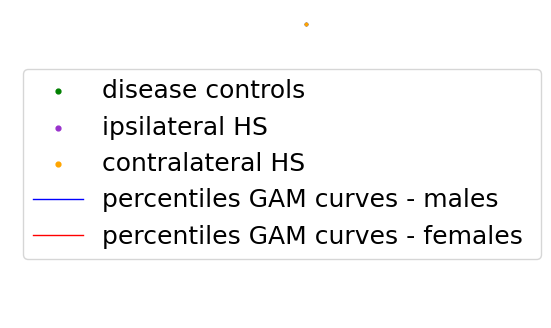

In [10]:
fig, ax = plt.subplots(1,1, figsize=(4,4))


ax.scatter(1,1, c='green',s=3, alpha=1, label='disease controls')
ax.scatter(1,1, c='darkorchid',s=3, alpha=1, label='ipsilateral HS')
ax.scatter(1,1, c='orange',s=3, alpha=1, label='contralateral HS')
for sex_i, sex in enumerate(sexes):
    ax.plot([0,0],[0,0], c=colors[sex_i], ls='-', linewidth= 1, alpha=1,  label=f'percentiles GAM curves - {sex}s ')

h, l =  ax.get_legend_handles_labels() # get labels and handles from ax1
ax.legend(h, l, markerscale=2., scatterpoints=1, loc='center left', fontsize=18)
ax.axis('off')

fig.savefig(os.path.join(output_path, 'legend_charts_combat_features_withpatients.png'), dpi=96, transparent =True, bbox_inches = 'tight' )

#### Compute percentiles for each subject

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |#######################

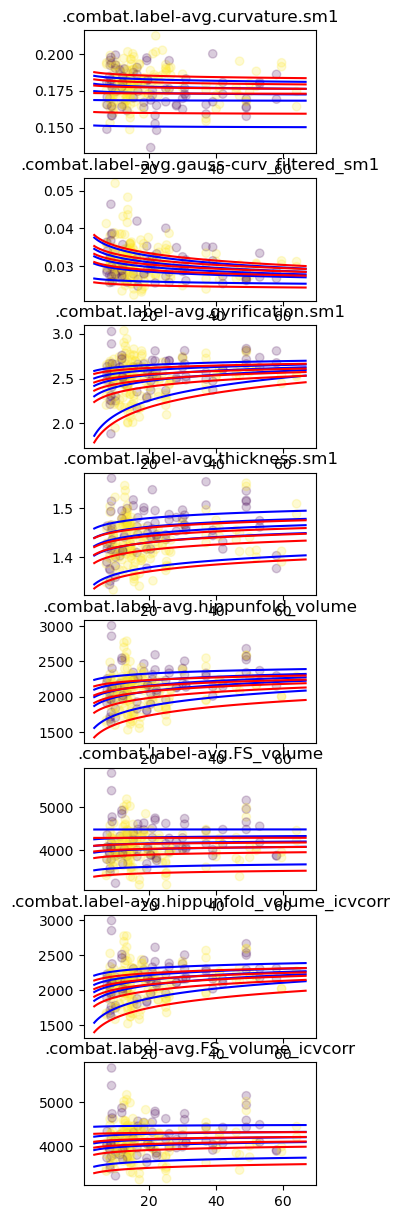

In [11]:
import numpy as np

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


fig, axs = plt.subplots(len(features),1, figsize=(3,15))
fit_log=True

for ii,feature in enumerate(features):
    subdf = df.dropna(subset=[feature])
    subdf_c = subdf[subdf['group']=='C']

    val = np.array(subdf_c[feature].copy())
    age = np.array(subdf_c['age_scan'].copy())
    sex = np.array(subdf_c['sex'].copy())
    
    #plot scatter point
    axs[ii].scatter(age, val, c=sex, alpha=0.2)
    axs[ii].set_title(feature)
    #create 100 curves from 0 to 100 centiles for male and female
    centiles = np.linspace(0.01,0.99, 99)
    data_dict = fit_GAM_age_sex(val, age, sex, fit_log=fit_log, percents=centiles, splines=4)
    #organise in matrix for each sex
    gams_predict_dict={}
    for sex_ind in [0,1]:
        gams_predict=[]
        age_range = data_dict[sex_ind]['age_range']
        for c, centile in enumerate(centiles):
            gams_predict.append(data_dict[sex_ind]['predict_vals_intervals'][centile])
            if c%20==0:
                axs[ii].plot(age_range, data_dict[sex_ind]['predict_vals_intervals'][centile], color=['blue','red'][sex_ind], label=i)
        gams_predict_dict[sex_ind] = np.array(gams_predict)
    
    centiles = centiles*100
    #For the subject age and sex, find how many rows are below the feature values of the subject (this will be the percentile)
    val_centiles_norm = []
    for i, row in df.iterrows():
        subject_age = row['age_scan']
        subject_sex = row['sex']
        subject_val = row[feature]
        #find the nearest age
        idx_age, age_XX = find_nearest(age_range, subject_age)
        if subject_val > gams_predict_dict[sex_ind][:, idx_age].max():
            pred_centile = 100
        elif subject_val < gams_predict_dict[sex_ind][:, idx_age].min():
            pred_centile = 0
        else:
            pred_centile = centiles[np.where(gams_predict_dict[sex_ind][:, idx_age] > subject_val)[0][0]]
        val_centiles_norm.append(pred_centile)

    #save the percentile values for each hippocampi feature
    df[f'.normCent{feature}'] = val_centiles_norm


#### Add the distribution of percentiles alongside the normative trajectories curves

In [13]:
import seaborn as sns

# variables
x_variable = 'age_scan' 
sexes=['male','female']
colors = ['blue', 'red']
fit_GAM=True
fit_log=True
percents = np.array([0.05, 0.95])
palette = {'ipsi':'darkorchid','contra':'orange', 'DC':'green', 'C':'grey' }
lims=[0,100]


# prepare group
df['class']= df['group']
df.loc[(df.lesional=='ipsi')&(df.group=='P'), 'class'] = 'ipsi'
df.loc[(df.lesional=='contra')&(df.group=='P'), 'class'] = 'contra'
df.loc[df.group=='DC', 'class'] = 'DC'  # take both hippocampi DC
df.loc[df.group=='C', 'class'] = np.nan
subdf=df.dropna(subset=['class'])


fig = plt.figure(figsize=(6,18))
gs1 = GridSpec(6, 2, wspace=0.3, hspace=0.3, width_ratios=[3, 1])
axs1 = []
axs2 = []


for i,feature in enumerate(sub_features):

    #plot scatter
    axs1.append(fig.add_subplot(gs1[i,0]))
    sns.scatterplot(data = subdf, x='age_scan', s=10, y=feature, hue="class", palette=palette, legend=False, ax=axs1[i])
    axs1[i].set_xlabel('age')
    axs1[i].set_ylabel(return_features_title(feature,features_title))


    #plot GAM curve 
    subdf_c = df[df['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    vals_c = subdf_c[feature].copy()

    if fit_GAM:
        controls_GAM = fit_GAM_age_sex(vals_c, age_c, sex_c, fit_log=fit_log, percents=percents, splines=4, add_mid_curve=False)
        
    for sex_i, sex in enumerate(sexes):
        if fit_GAM:
            im = plot_controls_chart(axs1[i], controls_GAM[sex_i], feature, color=colors[sex_i], fill_color=False, label=f'percentiles GAM curves - {sex}s')
    

    #plot percentiles distribution
    feature = f'.normCent{feature}'
    axs2.append(fig.add_subplot(gs1[i,1]))
    for classe in ['ipsi','contra','DC']:
        subdf_class = subdf[subdf['class']==classe].copy()
        sns.histplot(data = subdf_class, y=feature, bins= 20, kde=False, color=palette[classe], stat='percent', alpha=0.5, legend=False, ax=axs2[i])
    axs2[i].plot( np.array(lims),np.ones(2)*5, '--', color='red')
    axs2[i].plot( np.array(lims),np.ones(2)*6, '--', color='blue')
    axs2[i].plot( np.array(lims),np.ones(2)*95, '--', color='red')
    axs2[i].plot( np.array(lims),np.ones(2)*96, '--', color='blue')
    axs2[i].set_xlim(lims)
    axs2[i].spines['top'].set_visible(False)
    axs2[i].spines['right'].set_visible(False)
    axs2[i].spines['left'].set_visible(False)
    axs2[i].spines['bottom'].set_position('center')
    axs2[i].set_xticks([50,100])
    axs2[i].set_xticklabels(['50%','100%'], rotation=-90, fontsize=9)
    axs2[i].set_xlabel('')
    axs2[i].set_yticks([5,95])
    axs2[i].set_yticklabels([5,95])
    axs2[i].set_ylabel('percentiles', labelpad=-5, rotation=270)

plt.tight_layout()
fig.savefig(os.path.join(output_path, 'charts_combat_features_withpatients_distributions.png'), dpi=96, transparent =True , bbox_inches = 'tight')



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########             

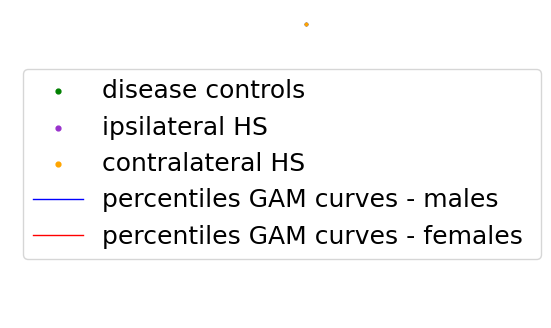

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,4))


ax.scatter(1,1, c='green',s=3, alpha=1, label='disease controls')
ax.scatter(1,1, c='darkorchid',s=3, alpha=1, label='ipsilateral HS')
ax.scatter(1,1, c='orange',s=3, alpha=1, label='contralateral HS')
for sex_i, sex in enumerate(sexes):
    ax.plot([0,0],[0,0], c=colors[sex_i], ls='-', linewidth= 1, alpha=1,  label=f'percentiles GAM curves - {sex}s ')

h, l =  ax.get_legend_handles_labels() # get labels and handles from ax1
ax.legend(h, l, markerscale=2., scatterpoints=1, loc='center left', fontsize=18)
ax.axis('off')

fig.savefig(os.path.join(output_path, 'legend_charts_combat_features_withpatients.png'), dpi=96, transparent =True, bbox_inches = 'tight' )

In [15]:
# display the number of patients ipsilateral hippocampi outside the 5th and 95th percentiles per feature

subdf_ipsi = df[(df['group']=='P')&(df['lesional']=='ipsi')]
ntot=len(subdf_ipsi)
print(ntot)

percmin = 5
percmax = 95

for feature in sub_features:
    
    npercmin = (subdf_ipsi[f'.normCent{feature}']<=percmin).sum()
    npercmax = (subdf_ipsi[f'.normCent{feature}']>=percmax).sum()
    print(feature)
    print(f'percentage of ipsi HS outside {percmin} population: {round(npercmin/ntot*100,1)}')
    print(f'percentage of ipsi HS outside {percmax} population: {round(npercmax/ntot*100,1)}')

152
.combat.label-avg.hippunfold_volume_icvcorr
percentage of ipsi HS outside 5 population: 90.1
percentage of ipsi HS outside 95 population: 1.3
.combat.label-avg.thickness.sm1
percentage of ipsi HS outside 5 population: 63.2
percentage of ipsi HS outside 95 population: 3.3
.combat.label-avg.gyrification.sm1
percentage of ipsi HS outside 5 population: 88.2
percentage of ipsi HS outside 95 population: 1.3
.combat.label-avg.curvature.sm1
percentage of ipsi HS outside 5 population: 1.3
percentage of ipsi HS outside 95 population: 67.1
.combat.label-avg.gauss-curv_filtered_sm1
percentage of ipsi HS outside 5 population: 2.6
percentage of ipsi HS outside 95 population: 70.4
